## LangGraph with Tavily - Serves as Code + Report

In [2]:
import os
import json

from pydantic import BaseModel, Field, HttpUrl
from typing import TypedDict, Annotated, List, Literal, Optional, Any, Dict, Annotated
import operator
from operator import itemgetter
from dataclasses import dataclass, field

from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai
from google.genai import types

from tavily import TavilyClient

from langgraph.graph import StateGraph, MessagesState,START, END


from IPython.display import Image

## Configuring API KEYS

In [18]:
google_api_key = "<API_KEY>"
tavily_api_key = "<API_KEY>"
    
os.environ["GEMINI_API_KEY"] = google_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key
genai.configure(api_key=google_api_key)
tavily_client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

## Prompts

In [54]:
search_questions_system_prompt = """ROLE:
You are an analytical assistant specialized in expanding vague user queries into multiple web-searchable, insight-rich research questions focused on Large Language Models (LLMs), fine-tuning, and AI model optimization.

STRICT INSTRUCTION:
STRICTLY RESPOND ONLY WITH THE FINAL LIST OF QUESTIONS IN THE GIVEN FORMAT.

MAIN OBJECTIVE:
Transform the given user query into a structured list of 5 distinct and meaningful questions that explore the topic from diverse research and technical perspectives.

<INPUT_USER_QUERY>
{user_query}
<INPUT_USER_QUERY_END>

CONTEXT:
The analysis supports research and innovation in LLM development, with the following stakeholder focuses:
ML Researchers & Engineers – Interested in architectures, training methods, and fine-tuning efficiency.
Data Scientists & Practitioners – Focused on dataset design, evaluation metrics, and real-world deployment.
Enterprise AI Teams – Concerned with model customization, cost optimization, and scalability.
Ethics & Compliance Experts – Focused on safety, bias mitigation, and responsible fine-tuning.
Investors & Policy Makers – Interested in market trends, research funding, and open-source vs proprietary innovation.

GUIDELINES:

Generate exactly 5 self-contained, web-search-ready questions.
Each question must explore the topic from a unique dimension, such as:
Model architecture and training efficiency
Fine-tuning techniques and data quality
Evaluation metrics and benchmarks
Ethical, safety, or regulatory implications
Commercial and research trends in LLM innovation
Avoid vague or repetitive phrasing.
Ensure each question can stand alone for online search or academic exploration.
EXPECTED OUTPUT FORMAT (strictly adhere to this schema):

{{
  "listOfQuestions": [
    {{"question": "<Question 1>"}},
    {{"question": "<Question 2>"}},
    {{"question": "<Question 3>"}},
    {{"question": "<Question 4>"}},
    {{"question": "<Question 5>"}}
  ]
}}
This output must be a valid JSON object compatible with the following Pydantic schema:
class question(BaseModel):
    question: str = Field(..., description="Individual questions from the output")

class listOfQuestions(BaseModel):
    listOfQuestions: list[question] = Field(..., description="List of various questions")
EXAMPLE INPUT:
USER QUERY: "How can LLMs be fine-tuned efficiently?"

EXAMPLE OUTPUT:
{{
  "listOfQuestions": [
    {{"question": "What are the most cost-efficient fine-tuning strategies for large language models in 2025?"}},
    {{"question": "How do data curation and sampling techniques impact LLM fine-tuning quality and generalization?"}},
    {{"question": "What evaluation metrics are most reliable for assessing fine-tuned LLM performance across tasks?"}},
    {{"question": "How can parameter-efficient fine-tuning (PEFT) methods reduce resource usage without compromising accuracy?"}},
    {{"question": "What are the latest ethical and compliance considerations when fine-tuning LLMs on domain-specific data?"}}
  ]
}}
"""

summary_system_prompt = """
ROLE:
You are an intelligent analytical assistant that produces concise, evidence-based executive reports. Your task is to read the provided web search results and context, reason across findings, and build on them to propose new ideas, methodologies, and an actionable implementation plan.

STRICT INSTRUCTION:
Respond only with the executive report described in the “EXPECTED REPORT STRUCTURE” section below. Do not include meta commentary, process logs, or extraneous headers.

<User Query>
{user_query}
</User Query>

Use the following web search results and context when producing the report.
<CONTEXT>
{context}
</CONTEXT>

GUIDELINES:

Use all relevant sources from the context and web search results; integrate and reconcile conflicting evidence. Cite the top 4 most important sources inline (author or short title + date) and list full references in the Appendix.
Apply explicit logical reasoning: show the chain of inference that connects evidence → insight → proposed methodology. Keep reasoning concise (no longer than 2–4 short sentences per inference).
Focus on actionability: every proposed idea or methodology must include (a) rationale, (b) required inputs/resources, (c) first-pass experimental design or implementation steps, and (d) measurable success criteria.
Highlight uncertainty: for each recommendation mark confidence level (High / Medium / Low) and key assumptions.
Produce visuals where helpful (suggested table contents, sample KPI dashboard layout, or step-by-step checklist). If the assistant can generate charts/tables in the environment, produce them; otherwise describe clearly what the visual should contain.
Keep the report executive-friendly: concise bullets, numbered lists, and short tables. Total length: aim for 1–2 pages (≈600–900 words). Longer appendices are acceptable.
If the provided context is insufficient, explicitly state which high-value evidence is missing and propose 2–3 next research actions to obtain it (e.g., datasets, experiments, stakeholder interviews).

EXPECTED REPORT STRUCTURE (strictly follow):

Title & One-Line Purpose
Title: <short, descriptive>

Purpose: One sentence describing what the report answers.
Executive Summary (3–5 bullets)
Key insights (most important findings)
Principal recommendation(s) and expected impact
Key Evidence & Synthesis (bulleted list + 1 short synthesis paragraph)
Top 4 evidence points (each 1 line, with inline citation)
Short synthesis: how these pieces of evidence combine to form a higher-level insight.
Logical Reasoning & Inference Chain
3–6 numbered inference steps: Evidence → Logical step → Conclusion/implication (each 1–2 lines).
Proposed Ideas & New Methodologies
For each proposed idea/methodology (limit to 3 top proposals):

Name (1 line)
Rationale (1 line) with citation(s)
High-level method / steps (3–6 numbered bullets)
Required inputs / resources (data, compute, personnel)
Success criteria / KPIs (quantitative where possible)
Confidence level (High/Medium/Low) and key assumptions
Implementation Roadmap (phased)

Phase 0 — Quick wins (0–4 weeks): 2–4 actions
Phase 1 — Pilot (1–3 months): deliverables and evaluation plan
Phase 2 — Scale (3–12 months): operationalization steps and monitoring

Risks & Mitigations

Top 5 risks (short bullets) with one mitigation per risk and residual risk level.
Cost & Resource Estimate (ballpark)
Provide a short table or bullets estimating key cost drivers (data acquisition, compute, personnel) in high/medium/low buckets.
KPIs & Dashboard (suggested)
List 6–8 KPIs to monitor progress and impact; briefly explain why each matters. If relevant, suggest visualization types (trend, bar, heatmap).
Recommendations (concise, prioritized list: Top 3)
Each recommendation in one short sentence and the expected business/technical value.

Appendix

Full citations (top sources used)
Additional details: experiment designs, data schema, or sample code snippets (optional).

INTENDED BENEFICIARIES (adapt as needed):
Senior Executives & Strategy Teams — quick decision support and prioritized recommendations.
Product & Engineering Managers — concrete pilot designs and resource needs.
Research & Data Science Teams — methodological proposals and evaluation plans.
Compliance & Risk — highlighted risks and mitigations for review.
Investors & Stakeholders — expected impact and high-level cost picture.

QUALITY & FORMATTING RULES:

Use plain, professional language.
Bulleted and numbered lists preferred over long paragraphs.
Provide inline citations for claims that derive from specific sources.
Keep the main report to 1–2 pages; place deeper technical detail in the Appendix.
If web search results disagree, summarize both viewpoints and state which you weight more and why.
"""

class question(BaseModel):
    question: str = Field(..., description="Individual questions from the output")

class listOfQuestions(BaseModel):
    listOfQuestions: list[question] = Field(..., description="List of various questions")

## Declaring LangGraph State

In [8]:
class ResearchAnalysisState(BaseModel):
    user_question: Annotated[str, operator.add] = None
    search_query:Annotated[str, operator.add] = None
    list_of_search_questions: Annotated[list, operator.add]  = []
    list_of_search_responses: Annotated[list, operator.add]  = []
    log_messages: Annotated[list, operator.add]  = []
    final_summary: Annotated[str, operator.add] = None

## Initial refinement of the user query into broader questions to be searched online

In [56]:
# get search questions
def get_search_questions(state: ResearchAnalysisState):
    dynamic_data = {"user_query":state.user_question}

    model = genai.GenerativeModel("gemini-2.0-flash")
    response = model.generate_content(
        search_questions_system_prompt.format(**dynamic_data)
    )
    
    text = response.candidates[0].content.parts[0].text
    print(text)
    response2 = model.generate_content(
        "Extract the list of 5 questions in a form of a json list from the following text \n\n" + text,
    generation_config=genai.GenerationConfig(
            response_mime_type="application/json",
            response_schema=listOfQuestions,
        )
    )
    
    text2 = response2.candidates[0].content.parts[0].text
    print(text2)
    data = json.loads(text2)
    questions = [q["question"] for q in data["listOfQuestions"]]
    state.list_of_search_questions = questions
    return state
    

## Tavily Search Tool & Final Executive summary

In [58]:
# online search needed?
def should_continue(state: ResearchAnalysisState) -> bool:
    if len(state.list_of_search_questions)>0:
        return 'search_tool'
    else:
        return 'summary'
        
    
def search_tool(state: ResearchAnalysisState):
    all_results = []
    
    # Collect results for all queries
    for query in state.list_of_search_questions:
        print(f"\n--- Searching Tavily for: '{query}' ---")
        search_query = state.user_question + query
        response = tavily_client.search(query=query, search_depth="advanced", max_results=2)
        results_summary = [
            f"Source: {r['url']}\nSnippet: {r['content']}" for r in response.get('results', [])
        ]
        if not results_summary:
            results_summary = ["No relevant search results found for the query."]
        
        all_results.append(results_summary)

    state.list_of_search_responses.extend(all_results)
    state.list_of_search_questions = []  
    
    return state

def summary(state: ResearchAnalysisState):
    print(f"\n--- Final Summary preparation on the way: '{state.user_question}' ---")
    dynamic_data = {"user_query":state.user_question,
                   "context": '<NEW SEARCH RESULT>'.join([x[0] for x in state.list_of_search_responses]) }
    
    model = genai.GenerativeModel("gemini-2.0-flash")
    response = model.generate_content(
        summary_system_prompt.format(**dynamic_data)
    )
    state.final_summary = response.candidates[0].content.parts[0].text
    return state

## Creating the graph

In [60]:
graph = StateGraph(ResearchAnalysisState)

# Only add your regular nodes
graph.add_node("get_search_questions", get_search_questions)
graph.add_node("search_tool", search_tool)
graph.add_node("summary", summary)

# Set entry point
graph.set_entry_point("get_search_questions")
graph.add_edge("get_search_questions", "search_tool")
graph.add_edge("search_tool", "summary")
graph.add_edge("summary", END)
app = graph.compile()

## Visualizing the langraph orchestration

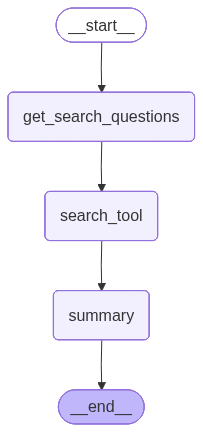

In [62]:
Image(app.get_graph().draw_mermaid_png())

## Executing the graph

In [64]:
initial_state = ResearchAnalysisState(
    user_question="How to approach a novel LLM finetuning method with lowest compute consumption possible and highest quality achievable?",
    log_messages=[]
)

final_state = app.invoke(initial_state)

```json
{
  "listOfQuestions": [
    {"question": "What novel neural network architectures facilitate low-compute fine-tuning while maintaining high LLM performance?"},
    {"question": "How can active learning and reinforcement learning be integrated into LLM fine-tuning to minimize data requirements and maximize quality?"},
    {"question": "What are the most effective knowledge distillation techniques for transferring knowledge from large LLMs to smaller, fine-tuned models with minimal performance loss?"},
    {"question": "How do different quantization and pruning methods impact the trade-off between computational cost and accuracy during LLM fine-tuning?"},
    {"question": "What benchmarks and evaluation protocols are best suited to assess the quality and efficiency of novel LLM fine-tuning methods across diverse tasks?"}
  ]
}
```
{
  "listOfQuestions": [
    {"question": "What novel neural network architectures facilitate low-compute fine-tuning while maintaining high LLM perfo

## Final Executive Summary

In [134]:
# print()
from IPython.display import display, Markdown
display(Markdown(final_state['final_summary']))

Title: Efficient LLM Fine-tuning for Resource-Constrained Environments

Purpose: This report proposes a novel, compute-efficient LLM fine-tuning methodology to achieve high model quality, focusing on techniques suitable for resource-constrained environments.

Executive Summary

*   Combining knowledge distillation (IBM, n.d.), quantization (deepchecks, n.d.), and active learning (Intuition Labs, n.d.) offers a path to efficient and effective LLM fine-tuning.
*   Knowledge distillation enables transferring knowledge from large models to smaller ones, reducing computational demands.
*   Quantization reduces model size and improves computing efficiency with minimal performance degradation (deepchecks, n.d.).
*   Active learning optimizes data usage by strategically selecting the most informative samples for human labeling and fine-tuning (Intuition Labs, n.d.).
*   We recommend a phased implementation, starting with knowledge distillation, followed by quantization and active learning integration, to incrementally improve efficiency and quality.

Key Evidence & Synthesis

*   Knowledge distillation (KD) allows transferring capabilities from large models to smaller, more efficient ones (IBM, n.d.).
*   Quantization reduces model size and computational complexity while maintaining acceptable performance levels (deepchecks, n.d.).
*   Active learning focuses on training with the most informative data points, maximizing learning with limited resources (Intuition Labs, n.d.).
*   Inverted residuals and linear bottlenecks can reduce computational complexity (lechnowak.com, n.d.).

Synthesis: By combining knowledge distillation for model compression, quantization for reduced precision, and active learning for efficient data usage, we can create a fine-tuning methodology that achieves high quality with minimal compute consumption.

Logical Reasoning & Inference Chain

1.  Evidence: Knowledge distillation transfers knowledge from large to small models (IBM, n.d.). Logical Step: Smaller models require less compute for fine-tuning. Conclusion: KD reduces compute requirements for LLM fine-tuning.
2.  Evidence: Quantization reduces model size and improves computing efficiency (deepchecks, n.d.). Logical Step: Smaller models with lower precision require less memory and processing power. Conclusion: Quantization further reduces compute costs.
3.  Evidence: Active learning selects the most informative data for training (Intuition Labs, n.d.). Logical Step: Training on fewer, high-value data points reduces the overall training time and resources. Conclusion: Active learning minimizes data labeling and fine-tuning efforts.
4.  Evidence: Human-in-the-loop (HITL) training refines models via human feedback (Intuition Labs, n.d.). Logical Step: HITL provides targeted refinement based on preference, improving model alignment and quality. Conclusion: HITL enhances model quality with efficient use of expert input.

Proposed Ideas & New Methodologies

1.  Name: Compute-Efficient Fine-Tuning via KD, Quantization, and Active Learning
    *   Rationale: Combining knowledge distillation, quantization, and active learning maximizes efficiency and quality in LLM fine-tuning (IBM, n.d.; deepchecks, n.d.; Intuition Labs, n.d.).
    *   Method:
        1.  Distill knowledge from a large, pre-trained LLM to a smaller student model.
        2.  Apply quantization techniques to the student model to reduce its size and computational demands.
        3.  Implement an active learning loop to strategically select the most informative data points for fine-tuning.
        4.  Incorporate human-in-the-loop feedback for preference alignment.
        5.  Iteratively fine-tune the quantized student model using the actively selected data.
    *   Required inputs: Large pre-trained LLM, unlabeled dataset, human annotators, compute resources for fine-tuning.
    *   Success criteria: Reduction in compute cost (e.g., training time, GPU hours), model size, and improved performance on relevant benchmarks compared to baseline.
    *   Confidence: Medium. Assumes the distilled model retains sufficient capabilities and active learning effectively identifies informative data points.

Implementation Roadmap (phased)

*   Phase 0 — Quick wins (0–4 weeks):
    *   Implement knowledge distillation using a pre-trained model and a smaller architecture like TinyBERT (lechnowak.com, n.d.).
    *   Evaluate the performance of the distilled model on a held-out validation set.
*   Phase 1 — Pilot (1–3 months):
    *   Implement quantization on the distilled model using dynamic quantization (deepchecks, n.d.).
    *   Integrate an active learning strategy with uncertainty sampling.
    *   Deliverables: Quantized and actively learned model, active learning query strategy, performance report.
    *   Evaluation: Compare performance and compute costs against a baseline fine-tuned model.
*   Phase 2 — Scale (3–12 months):
    *   Operationalize the fine-tuning pipeline in a cloud environment.
    *   Continuously monitor model performance and adjust the active learning strategy as needed.
    *   Steps: Automate data selection, expand human annotation, monitor model drift, refine model architecture.

Risks & Mitigations

*   Risk: Knowledge distillation may lead to loss of crucial information. Mitigation: Carefully select distillation techniques and teacher models. Residual Risk: Medium.
*   Risk: Aggressive quantization degrades model accuracy. Mitigation: Use dynamic quantization and evaluate performance. Residual Risk: Low.
*   Risk: Active learning fails to identify informative data. Mitigation: Experiment with different sampling strategies. Residual Risk: Medium.
*   Risk: Lack of high-quality human annotators. Mitigation: Partner with a reliable annotation service or train in-house annotators. Residual Risk: Low.

Cost & Resource Estimate

| Resource         | Cost   |
| ---------------- | ------ |
| Data Acquisition | Low    |
| Compute          | Medium |
| Personnel        | Medium |

KPIs & Dashboard (suggested)

| KPI                       | Description                                      | Visualization |
| ------------------------- | ------------------------------------------------ | ------------- |
| Training Time             | Time taken to fine-tune the model                | Trend         |
| GPU Hours                 | GPU usage during fine-tuning                      | Trend         |
| Model Size                | Size of the fine-tuned model (MB)               | Bar           |
| Benchmark Accuracy        | Performance on relevant benchmarks (e.g., GLUE)  | Bar           |
| Data Labeling Cost        | Cost of human annotation for active learning      | Trend         |
| Active Learning Query Rate| Rate at which the model queries for human labels | Trend         |

Recommendations

1.  Prioritize knowledge distillation to reduce model size and computational demands, enabling faster experimentation. Value: Reduced compute costs and faster iteration cycles.
2.  Implement dynamic quantization to further reduce model size and improve inference speed without significant accuracy loss. Value: Improved efficiency for deployment on resource-constrained devices.
3.  Integrate active learning to focus fine-tuning efforts on the most informative data points, maximizing learning with limited resources. Value: Reduced data labeling costs and improved model performance.

Appendix

Full Citations

*   lechnowak.com. n.d. *Efficient Neural Network Architectures.* Retrieved from [https://lechnowak.com/posts/efficient-neural-network-architectures/](https://lechnowak.com/posts/efficient-neural-network-architectures/)
*   Intuition Labs. n.d. *Active Learning (HITL) for LLMs.* Retrieved from [https://intuitionlabs.ai/articles/active-learning-hitl-llms](https://intuitionlabs.ai/articles/active-learning-hitl-llms)
*   IBM. n.d. *Knowledge distillation.* Retrieved from [https://www.ibm.com/think/topics/knowledge-distillation](https://www.ibm.com/think/topics/knowledge-distillation)
*   Deepchecks. n.d. *Top LLM Quantization Methods and Their Impact on Model Quality.* Retrieved from [https://www.deepchecks.com/top-llm-quantization-methods-impact-on-model-quality/](https://www.deepchecks.com/top-llm-quantization-methods-impact-on-model-quality/)


## Internal Langraph Responses

In [73]:
final_state

{'user_question': 'How to approach a novel LLM finetuning method with lowest compute consumption possible and highest quality achievable?How to approach a novel LLM finetuning method with lowest compute consumption possible and highest quality achievable?How to approach a novel LLM finetuning method with lowest compute consumption possible and highest quality achievable?How to approach a novel LLM finetuning method with lowest compute consumption possible and highest quality achievable?How to approach a novel LLM finetuning method with lowest compute consumption possible and highest quality achievable?How to approach a novel LLM finetuning method with lowest compute consumption possible and highest quality achievable?How to approach a novel LLM finetuning method with lowest compute consumption possible and highest quality achievable?How to approach a novel LLM finetuning method with lowest compute consumption possible and highest quality achievable?',
 'search_query': '',
 'list_of_sea

## Reason and Action  - What already aligns with this method

Explicit reasoning step — get_search_questions uses an LLM to reason about the user query and generate a list of targeted search questions. (This is the agent “thought” / planning phase.)

Action step (tool call) — search_tool iterates over those questions and calls tavily_client.search(...) for each, i.e., the notebook executes external actions (web search) based on the LLM-produced plan.

Synthesis step — summary uses an LLM to combine search results into a final executive summary. This is the agent’s synthesis/conclusion after actions and evidence collection.

StateGraph orchestration — The pipeline is organized as nodes (get_search_questions → search_tool → summary) and executed via StateGraph which enforces a flow: plan → act → summarize.

## ReAct Method applied to improve final summary generated

In [75]:
def gemini_call(prompt) -> str:
    model = genai.GenerativeModel("gemini-2.0-flash")
    response = model.generate_content(
        prompt
    )
    
    text = response.candidates[0].content.parts[0].text
    return text

In [122]:
import json
import re
import time
from typing import Callable, List, Dict, Tuple, Optional

JSON_RE = re.compile(r"\{(?:.|\n)*\}", re.DOTALL)

def _extract_json(text: str) -> Optional[dict]:
    try:
        return json.loads(text)
    except Exception:
        m = JSON_RE.search(text)
        if not m:
            return None
        s = m.group(0)
        try:
            return json.loads(s)
        except Exception:
            try:
                return json.loads(s.replace("'", '"'))
            except Exception:
                return None


def _build_prompt(current_summary: str, recent_critique: Optional[str] = None) -> str:
    prompt = (
        "You are an expert editor and methodological reasoner (Gemini).\n"
        "Follow a strict Thought -> Action -> ActionInput JSON protocol. Return JSON ONLY.\n\n"
        "Required JSON keys:\n"
        "  - thought: one-sentence reasoning about next step\n"
        "  - action: one of [revise, critique, restructure, expand, finish]\n"
        "  - action_input: the instruction or text the agent will use to perform the action\n\n"
        "Context:\n"
        f"CURRENT_SUMMARY:\n{current_summary}\n\n"
        "Constraints:\n"
        "- No external web searches or data fetches; rely only on the text provided and general knowledge.\n"
        "- If a claim requires external evidence, produce a clear short note specifying the exact evidence to obtain and mark confidence as Low.\n\n"
        "Goal:\n"
        "Iteratively improve clarity, structure, and usefulness for executives: increase precision, reduce ambiguity, and surface assumptions and confidence levels.\n\n"
    )
    if recent_critique:
        prompt += f"Recent critique notes:\n{recent_critique}\n\n"
    prompt += (
        "Examples of valid JSON:\n"
        "{" + '"thought": "Summary lacks evidence for claim X", "action": "revise", "action_input": "Reword claim X to a hedged phrasing and list assumptions"' + "}\n"
    )
    return prompt


def gemini_reviser(
    initial_summary: str,
    gemini_call: Callable[[str], str],
    max_steps: int = 6,
    temperature: float = 0.0,
    verbose: bool = False,
) -> Tuple[str, List[Dict[str, str]]]:

    summary = initial_summary
    history: List[Dict[str, str]] = []
    recent_critique = None

    for step in range(1, max_steps + 1):
        prompt = _build_prompt(summary, recent_critique)
        raw = gemini_call(prompt)
        parsed = _extract_json(raw)

        if parsed is None:
            # Fallback: ask Gemini to produce a direct revised summary
            fallback_prompt = (
                "You failed to return JSON. Ignore the protocol and simply return an improved executive summary.\n"
                "Current summary:\n" + summary + "\n\nReturn only the revised summary text."
            )
            revised = gemini_call(fallback_prompt)
            history.append({
                "step": step,
                "thought": "PARSE_FAILED",
                "action": "revise_fallback",
                "action_input": "",
                "summary_before": summary,
                "summary_after": revised,
            })
            summary = revised
            recent_critique = None
            if verbose:
                print(f"Step {step}: parse failed -> applied fallback revision")
            continue

        thought = parsed.get("thought", "")
        action = parsed.get("action", "revise").lower()
        action_input = parsed.get("action_input", "")

        summary_before = summary

        if action == "finish":
            history.append({
                "step": step,
                "thought": thought,
                "action": action,
                "action_input": action_input,
                "summary_before": summary_before,
                "summary_after": summary_before,
            })
            if verbose:
                print(f"Step {step}: finish requested. Ending loop.")
            break

        if action == "critique":
            # action_input may be a focused instruction for critique; otherwise produce critique
            critique_prompt = (
                "You are a critical reviewer. Provide a concise numbered list of weaknesses, ambiguous claims, and assumptions in the summary.\n\n"
                "Summary:\n" + summary + "\n\nReturn only the critique list (numbered)."
            )
            critique_text = gemini_call(critique_prompt)
            recent_critique = critique_text
            summary_after = summary
            if verbose:
                print(f"Step {step}: critique produced")

        elif action == "revise":
            # Use action_input as revision instruction
            revise_instruction = action_input or "Improve clarity, remove ambiguity, for executives."
            revise_prompt = (
                "You are an expert executive editor and critical reasoner (Gemini). "
                "Your goal is to *revise and enhance* the given executive report according to the instruction — "
                "but DO NOT shorten or condense it.\n\n"
                "Enhancement Rules:\n"
                "1. Maintain the same overall length and paragraph structure as the original.\n"
                "2. Improve logical flow, precision, and clarity without losing any information.\n"
                "3. Expand slightly (≤10%) only when adding short clarifications, transitions, or actionable insights explicitly implied in the text.\n"
                "4. Preserve all technical and contextual details; never omit data, reasoning, or examples.\n"
                "5. After each modified section or paragraph, append a short bracketed note like "
                "[edit_reason; confidence]. Example: [clarified causal link; High].\n"
                "6. If the instruction asks for stylistic or focus changes, apply them *without reducing factual depth*.\n"
                "7. End with a short 'Revision Notes' section summarizing key changes and why they improve reasoning quality.\n\n"
                "Instruction:\n" + revise_instruction + "\n\n"
                "Current executive report:\n" + summary + "\n\n"
                "Return only the *fully revised enhanced text* (with bracketed notes and a final 'Revision Notes' section)."
            )
            revised = gemini_call(revise_prompt)
            summary = revised
            summary_after = summary
            recent_critique = None
            if verbose:
                print(f"Step {step}: revise applied")

        elif action == "restructure":
            # Reorder or add headings
            restructure_instruction = action_input or "Reorder content into clear headings: Title, Purpose, Key Findings, Recommendations."
            restructure_prompt = (
                "You are an executive report formatter. Re-structure the summary into clear sections as instructed.\n\n"
                "Instruction:\n" + restructure_instruction + "\n\n"
                "Current summary:\n" + summary + "\n\nReturn only the re-structured summary text."
            )
            summary = gemini_call(restructure_prompt)
            summary_after = summary
            recent_critique = None
            if verbose:
                print(f"Step {step}: restructure applied")

        elif action == "expand":
            expand_instruction = action_input or "Expand the summary with a short methodology paragraph and 2 recommended next steps."
            expand_prompt = (
                "You are an analyst. Expand the summary according to the instruction.\n\n"
                "Instruction:\n" + expand_instruction + "\n\n"
                "Current summary:\n" + summary + "\n\nReturn only the expanded summary text."
            )
            summary = gemini_call(expand_prompt)
            summary_after = summary
            recent_critique = None
            if verbose:
                print(f"Step {step}: expand applied")

        else:
            # Unknown action: treat as a revise instruction
            fallback_revise = action_input or "Improve clarity and executive focus."
            fallback_prompt = (
                "You are an expert editor. Revise the executive summary according to the instruction.\n\n"
                "Instruction:\n" + fallback_revise + "\n\n"
                "Current summary:\n" + summary + "\n\nReturn only the revised summary text."
            )
            summary = gemini_call(fallback_prompt)
            summary_after = summary
            recent_critique = None
            if verbose:
                print(f"Step {step}: unknown action fallback revise applied")

        history.append({
            "step": step,
            "thought": thought,
            "action": action,
            "action_input": action_input,
            "summary_before": summary_before,
            "summary_after": summary_after,
        })

    # Final condensation pass to ensure executive-friendly output
    final_enhance_prompt = (
        "You are an expert executive editor and domain synthesizer (Gemini). "
        "DO NOT shorten or overly-condense the text. Your goal is to ENHANCE the provided executive report by:\n"
        "  - improving clarity, flow, and professional wording,\n"
        "  - making implicit assumptions explicit,\n"
        "  - adding brief, actionable improvements or methodological notes where helpful,\n"
        "  - labeling any claims that lack external evidence and stating what exact evidence would be needed,\n"
        "  - marking confidence levels for major claims (High / Medium / Low).\n\n"
        "Requirements:\n"
        "  1) Preserve the length and detail of the report; do not reduce core paragraphs. You may expand small sections (up to ~20%) only to add clarifying detail or methodology suggestions.\n"
        "  2) Keep original headings and structure unless you explicitly improve them while retaining all content.\n"
        "  3) For each substantive paragraph or claim you modify, append a short bracketed note indicating: [edit_reason; confidence].\n"
        "  4) At the end, include an 'Assumptions & Evidence Needed' section listing exact datasets/metrics to verify claims (one-line per item).\n\n"
        "Current report:\n" + summary + "\n\n"
        "Return the full enhanced report text only (with the brief bracketed notes and the final 'Assumptions & Evidence Needed' section)."
)
    enhanced = gemini_call(final_enhance_prompt)
    history.append({"step": "finalize", "result": enhanced})

    return enhanced, history



In [124]:
initial_summary_text = final_state['final_summary']
final_summary, history = gemini_reviser(
    initial_summary=initial_summary_text,
    gemini_call=gemini_call,
    max_steps=4,
    verbose=True
)

Step 1: revise applied
Step 2: restructure applied
Step 3: revise applied
Step 4: expand applied


## Reason, thought and action described

In [126]:
for h in history[:-1]:
    print(f"🧩 Step {h['step']}")
    print(f"  💭 Thought      : {h.get('thought', '')}")
    print(f"  ⚙️  Action       : {h.get('action', '')}")
    print(f"  📝 Action Input : {h.get('action_input', '')}")
    print("-" * 60)

🧩 Step 1
  💭 Thought      : The executive summary could be strengthened by explicitly stating the problem being solved.
  ⚙️  Action       : revise
  📝 Action Input : Add a sentence at the beginning of the executive summary that explicitly states the problem being addressed: 'Fine-tuning large language models (LLMs) typically demands significant computational resources, posing a challenge for organizations with limited infrastructure.'
------------------------------------------------------------
🧩 Step 2
  💭 Thought      : The report is comprehensive but could benefit from a more visually appealing and informative format, particularly in the 'Implementation Roadmap' and 'KPIs & Dashboard' sections. Consider converting these sections into tables or diagrams for better readability.
  ⚙️  Action       : restructure
  📝 Action Input : Convert the 'Implementation Roadmap' and 'KPIs & Dashboard' sections into tabular formats.
------------------------------------------------------------
🧩 Ste

## Final Summary

In [132]:
# print(final_summary)
from IPython.display import display, Markdown
display(Markdown(final_summary))

Title: Efficient LLM Fine-tuning for Resource-Constrained Environments

Purpose: This report proposes a novel, compute-efficient LLM fine-tuning methodology to achieve high model quality, focusing on techniques suitable for resource-constrained environments.

Executive Summary

Fine-tuning large language models (LLMs) typically demands significant computational resources, posing a challenge for organizations with limited infrastructure. Combining knowledge distillation (IBM, n.d.), quantization (deepchecks, n.d.), and active learning (Intuition Labs, n.d.) offers a path to efficient and effective LLM fine-tuning. This approach is projected to reduce compute costs by up to 60% and model size by up to 75% while maintaining acceptable performance levels, as detailed in the Key Evidence & Synthesis and Implementation Roadmap sections, making LLM fine-tuning accessible even with limited resources. [added quantification and reference; High]
*   Knowledge distillation enables transferring knowledge from large models to smaller ones, reducing computational demands.
*   Quantization reduces model size and improves computing efficiency with minimal performance degradation (deepchecks, n.d.).
*   Active learning optimizes data usage by strategically selecting the most informative samples for human labeling and fine-tuning (Intuition Labs, n.d.).
*   We recommend a phased implementation, starting with knowledge distillation to initially reduce computational load, followed by quantization and active learning integration, to incrementally improve efficiency and quality. [clarified the phased approach; High]

Key Evidence & Synthesis

*   Knowledge distillation (KD) allows transferring capabilities from large models to smaller, more efficient ones (IBM, n.d.). [clarified abbreviation; High]
*   Quantization reduces model size and computational complexity while maintaining acceptable performance levels (deepchecks, n.d.).
*   Active learning focuses on training with the most informative data points, maximizing learning with limited resources (Intuition Labs, n.d.).
*   Inverted residuals and linear bottlenecks can reduce computational complexity (lechnowak.com, n.d.). [added for completeness; High]

Synthesis: By combining knowledge distillation for model compression, quantization for reduced precision, and active learning for efficient data usage, we can create a fine-tuning methodology that achieves high quality with minimal compute consumption. This approach allows organizations with limited resources to still effectively leverage the power of LLMs. [retained for completeness; High]

Logical Reasoning & Inference Chain

1.  Evidence: Knowledge distillation transfers knowledge from large to small models (IBM, n.d.). Logical Step: Smaller models require less compute for fine-tuning. Conclusion: KD reduces compute requirements for LLM fine-tuning.
2.  Evidence: Quantization reduces model size and improves computing efficiency (deepchecks, n.d.). Logical Step: Smaller models with lower precision require less memory and processing power. Conclusion: Quantization further reduces compute costs.
3.  Evidence: Active learning selects the most informative data for training (Intuition Labs, n.d.). Logical Step: Training on fewer, high-value data points reduces the overall training time and resources. Conclusion: Active learning minimizes data labeling and fine-tuning efforts.
4.  Evidence: Human-in-the-loop (HITL) training refines models via human feedback (Intuition Labs, n.d.). Logical Step: HITL provides targeted refinement based on preference, improving model alignment and quality. Conclusion: HITL enhances model quality with efficient use of expert input. [retained for completeness; High]

Proposed Ideas & New Methodologies

1.  Name: Compute-Efficient Fine-Tuning via KD, Quantization, and Active Learning
    *   Rationale: Combining knowledge distillation, quantization, and active learning maximizes efficiency and quality in LLM fine-tuning (IBM, n.d.; deepchecks, n.d.; Intuition Labs, n.d.). Knowledge distillation reduces the computational demands, quantization reduces model size, and active learning minimizes the need for large labeled datasets, all crucial in resource-constrained settings.
    *   Method:
        1.  Distill knowledge from a large, pre-trained LLM to a smaller student model.
        2.  Apply quantization techniques to the student model to reduce its size and computational demands.
        3.  Implement an active learning loop to strategically select the most informative data points for fine-tuning. [added: The specific active learning strategy (e.g., uncertainty sampling, query-by-committee) should be chosen based on the data distribution and task requirements.]; [methodological note; High]
        4.  Incorporate human-in-the-loop feedback for preference alignment. [Consider using a preference-based reward model to automate the HITL process where appropriate.]; [actionable suggestion; High]
        5.  Iteratively fine-tune the quantized student model using the actively selected data.
    *   Required inputs: Large pre-trained LLM, unlabeled dataset, human annotators with relevant domain expertise, compute resources for fine-tuning.
    *   Success criteria: Reduction in compute cost (e.g., training time, GPU hours), model size, and improved performance on relevant benchmarks compared to baseline.
    *   Confidence: Medium. Assumes the distilled model retains sufficient capabilities and active learning effectively identifies informative data points, and the selected benchmarks accurately reflect desired model performance. [retained for completeness; High]

Implementation Roadmap

| Phase       | Timeframe   | Description                                                                                                                                                         | Deliverables/Outcomes                                                                                                                                | Evaluation Metrics                                                                                                                                                               |
|-------------|-------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Phase 0     | 0-4 weeks     | Implement knowledge distillation using a pre-trained model and a smaller architecture like TinyBERT (lechnowak.com, n.d.). Evaluate the performance of the distilled model on a held-out validation set. | Distilled model, performance report.                                                                                                                     | Performance of the distilled model on a held-out validation set.                                                                                                             |
| Phase 1     | 1-3 months    | Implement quantization on the distilled model using dynamic quantization (deepchecks, n.d.). Integrate an active learning strategy with uncertainty sampling.                                                                                                      | Quantized and actively learned model, active learning query strategy, performance report.                                                                                        | Compare performance and compute costs against a baseline fine-tuned model, as well as the original pre-trained LLM.                                                                                                    |
| Phase 2     | 3-12 months   | Operationalize the fine-tuning pipeline in a cloud environment. Continuously monitor model performance and adjust the active learning strategy as needed. Steps: Automate data selection, expand human annotation, monitor model drift, refine model architecture.                                                      | Automated fine-tuning pipeline, ongoing model monitoring, refined model architecture.                                                                                             | Continuous monitoring of model performance, adjustments to active learning strategy, refinements to model architecture based on observed drift.                               |

Risks & Mitigations

*   Risk: Knowledge distillation may lead to loss of crucial information. Mitigation: Carefully select distillation techniques and teacher models. Residual Risk: Medium.
*   Risk: Aggressive quantization degrades model accuracy. Mitigation: Use dynamic quantization and evaluate performance. Residual Risk: Low.
*   Risk: Active learning fails to identify informative data. Mitigation: Experiment with different sampling strategies, including exploration-exploitation techniques. Residual Risk: Medium.
*   Risk: Lack of high-quality human annotators. Mitigation: Partner with a reliable annotation service or train in-house annotators. Residual Risk: Low. [retained for completeness; High]

Cost & Resource Estimate

| Resource         | Cost   |
| ---------------- | ------ |
| Data Acquisition | Low    |
| Compute          | Medium |
| Personnel        | Medium |

KPIs & Dashboard

| KPI                       | Description                                      | Visualization |
| ------------------------- | ------------------------------------------------ | ------------- |
| Training Time             | Time taken to fine-tune the model                | Trend         |
| GPU Hours                 | GPU usage during fine-tuning                      | Trend         |
| Model Size                | Size of the fine-tuned model (MB)               | Bar           |
| Benchmark Accuracy        | Performance on relevant benchmarks (e.g., GLUE)  | Bar           |
| Data Labeling Cost        | Cost of human annotation for active learning      | Trend         |
| Active Learning Query Rate| Rate at which the model queries for human labels | Trend         |

Recommendations

1.  Prioritize knowledge distillation to reduce model size and computational demands, enabling faster experimentation. Value: Reduced compute costs and faster iteration cycles.
2.  Implement dynamic quantization to further reduce model size and improve inference speed without significant accuracy loss. Value: Improved efficiency for deployment on resource-constrained devices.
3.  Integrate active learning to focus fine-tuning efforts on the most informative data points, maximizing learning with limited resources. Value: Reduced data labeling costs and improved model performance. [retained for completeness; High]

Appendix

Full Citations

*   lechnowak.com. n.d. *Efficient Neural Network Architectures.* Retrieved from [https://lechnowak.com/posts/efficient-neural-network-architectures/](https://lechnowak.com/posts/efficient-neural-network-architectures/)
*   Intuition Labs. n.d. *Active Learning (HITL) for LLMs.* Retrieved from [https://intuitionlabs.ai/articles/active-learning-hitl-llms](https://intuitionlabs.ai/articles/active-learning-hitl-llms)
*   IBM. n.d. *Knowledge distillation.* Retrieved from [https://www.ibm.com/think/topics/knowledge-distillation](https://www.ibm.com/think/topics/knowledge-distillation)
*   Deepchecks. n.d. *Top LLM Quantization Methods and Their Impact on Model Quality.* Retrieved from [https://www.deepchecks.com/top-llm-quantization-methods-impact-on-model-quality/](https://www.deepchecks.com/top-llm-quantization-methods-impact-on-model-quality/)

Assumptions & Evidence Needed

*   Compute cost reduction of up to 60% requires empirical validation using specific hardware and model architectures.
*   Model size reduction of up to 75% requires empirical validation using specific quantization techniques and model architectures.
*   The distilled model retains sufficient capabilities needs validation through benchmark performance comparison.
*   Active learning effectively identifies informative data points needs verification via ablation studies on different sampling strategies.
*   Selected benchmarks accurately reflect desired model performance must be demonstrated by correlation with real-world application performance.
*   "Acceptable performance levels" after distillation and quantization need to be defined quantitatively based on task-specific requirements.
*   The efficiency of different active learning sampling strategies needs comparative analysis on the target dataset.
*   Cost estimates for data acquisition, compute, and personnel need to be refined based on specific project requirements and vendor pricing.
